# Assessment of comparability of sputum samples

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

To ensure comparability and quality of sputum samples, health-care workers provided video-guided instructions to all participants and asked them to only submit specimens collected during early-morning. The use of the sputum submission instructional video, for improvement of sputum quality, was previously validated by Mhalu and colleagues <cite data-cite="2542765/MA2XSZ9J"></cite>. At the time of specimen reception, laboratory technicians visually assessed quality and volume; second samples were requested if salivary-like (transparent and watery specimen with bubbles) specimens were submitted. Accepted sputum samples were transported from Temeke district hospital at <html>4&def;C</html> to the Bagamoyo Research and Training Center for processing. To further assess quantitatively the comparability of sputum samples across categories of TB disease manifestations, we randomly selected 30 sample-collection records and retrieved the registered volume of the collected sputum. We tested for differences in mean sputum volume across TB disease categories.

**References**
<div class="cite2c-biblio"></div>

In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-15


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(ggpubr)
library(ggsignif)
library(hrbrthemes)
hrbrthemes::import_roboto_condensed()
library(grid)
library(gridExtra)

## 1. Import files

**Tables with mapping IDs**

In [5]:
%%R
asv16s_mapping_ids_file <- "./data/raw/tz_spt_cases/sample_ids_mapping.txt"
wms_mapping_ids_file <- "data/raw/wms/wms_cases/sample_ids_mapping.txt"

asv16s_mapping_ids <- read.table(asv16s_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1)
wms_mapping_ids <- read.table(wms_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1)

print(head(asv16s_mapping_ids, n=3))
print(head(wms_mapping_ids, n=3))

       SpecimenID SubjectID seq_run
A00030     S00394    H00388    run1
A00034     S00426    H00421    run1
A00036     S00173    H00173    run1
       SpecimenID SubjectID
M00001     S00181    H00183
M00002     S00375    H00368
M00004        NC3          


**Sputum characteristics**

In [6]:
%%R
sputum_characteristics_file <- "./data/raw/metadata/sputum_quality_extended_renamed_cases.csv"
sputum_characteristics <- read.table(sputum_characteristics_file, header=TRUE, sep='\t', 
                                     stringsAsFactors=FALSE, row.names=1, na.strings=c('unknown',''))
head(sputum_characteristics, n=3)

         specdate        time condition volumeml tbscore worsetbscore
S00584 21/12/2015 09:00:00 AM    mucoid       NA       7       Severe
S00585 04/12/2015 11:20:00 AM    mucoid       NA       5         Mild
S00586 23/10/2015 08:40:00 AM    mucoid        7       5         Mild
       afbpositivity
S00584        3_plus
S00585        2_plus
S00586        1_plus


**TB patient clinical data**

In [7]:
%%R
patients_clinical_data_file <- "./data/raw/metadata/host_metadata.tsv"
patients_clinical_data <- read.table(patients_clinical_data_file, header=TRUE, sep='\t', 
                                     stringsAsFactors=FALSE, row.names=1, na.strings=c('unknown',''))
head(patients_clinical_data, n=3)

       smear_grading smear_grading_bin tbscore_bin tbscore xraysevere
H00084            2+              High        Mild       4       <NA>
H00205            2+              High        Mild       4       <NA>
H00208            1+               Low        Mild       4       <NA>
       filtration caviation micronode effusion lymphnode delaymed
H00084       <NA>      <NA>      <NA>     <NA>      <NA>      yes
H00205       <NA>      <NA>      <NA>     <NA>      <NA>      yes
H00208       <NA>      <NA>      <NA>     <NA>      <NA>       no
                tbdelay   male age      bmi    bmi_cat hblevel cd4count
H00084 Delay <= 3 weeks   male  34 21.70092 BMI >=18.5      NA      259
H00205 Delay <= 3 weeks   male  46 16.42099  BMI <18.5     9.1       NA
H00208   Delay >3 weeks female  26 18.58260 BMI >=18.5      NA       NA
            hiv whohivstage bacterial strepto legionella heamophilus mycoplasma
H00084 positive           1      <NA>    <NA>       <NA>        <NA>       <NA>
H00205 n

## 2. Assessment of comparability of sputum volume by categories of TB disease manifestations

**Assess normal distribution of sputum volume**

In [8]:
%%R
sputum_characteristics$smear_grading_bin <- factor(sputum_characteristics$afbpositivity)
sputum_characteristics$smear_grading_bin <- plyr::mapvalues(sputum_characteristics$smear_grading_bin, 
                                                            from=c("scanty","1_plus","2_plus","3_plus"),
                                                            to=c("Low", "Low", "High","High"))
sputum_characteristics$worsetbscore <- factor(sputum_characteristics$worsetbscore, levels=c("Mild","Severe"))
head(sputum_characteristics, n=3)

         specdate        time condition volumeml tbscore worsetbscore
S00584 21/12/2015 09:00:00 AM    mucoid       NA       7       Severe
S00585 04/12/2015 11:20:00 AM    mucoid       NA       5         Mild
S00586 23/10/2015 08:40:00 AM    mucoid        7       5         Mild
       afbpositivity smear_grading_bin
S00584        3_plus              High
S00585        2_plus              High
S00586        1_plus               Low


Lets check if the volumen of sputum collected per patient follows a normal distribution: 

In [9]:
%%R
sputum_volume_shapiro <- shapiro.test(sputum_characteristics$volumeml)
print(sputum_volume_shapiro)

sputum_volume_annotation <- c(c("Shapiro-Wilk~normality~test"), 
                               paste0("~~W ==", round(sputum_volume_shapiro$statistic), 
                                      "~(italic(p)== ", round(sputum_volume_shapiro$p.value,4), ")"))

sputum_volume_shapiro_plot <- ggqqplot(sputum_characteristics$volumeml, 
                                       title="Quantile-Quantile plot of sputum volume", 
                                       ylab="Sample (ml)") +
                              annotate("text", label=sputum_volume_annotation, x=-2, y=c(18,17), 
                                       hjust=0, parse=TRUE)
sputum_volume_shapiro_plot


	Shapiro-Wilk normality test

data:  sputum_characteristics$volumeml
W = 0.89304, p-value = 0.00789



Since, the sputum volume is not normally distributed, we applied a non-parametric test for comparison of means, the Wilcoxon test.

**Sputum volume by mycobacterial load in sputum**

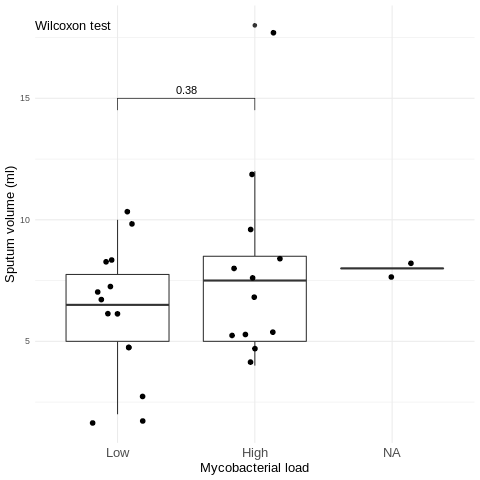

In [10]:
%%R
my_comparisons <- list( c("Low","High"))
sputum_volume_by_mycobacterial_load_plot <- ggplot(data=sputum_characteristics, aes(y=volumeml, x=smear_grading_bin)) + 
                                            geom_boxplot() + 
                                            geom_jitter(size=2, position=position_jitter(0.2)) + 
                                            stat_compare_means(aes(label=paste0("p = ",..p.format..)),
                                                               method="wilcox.test", label.y=15, 
                                                               comparisons=my_comparisons, na.rm=TRUE) + 
                                            annotate("text", label="Wilcoxon test", x=-Inf, y=18, hjust=0, 
                                                     size=4.5) + 
                                            labs(x="Mycobacterial load", y="Sputum volume (ml)") +
                                            theme_minimal() + 
                                            theme(plot.title = element_text(face="bold", hjust=0,size=14),
                                                  plot.subtitle = element_text(hjust=0,size=12),
                                                  axis.text.x=element_text(size=13), 
                                                  axis.title=element_text(size=13))
sputum_volume_by_mycobacterial_load_plot

**Sputum volume by severity of signs and symptoms (i.e clinical severity)**

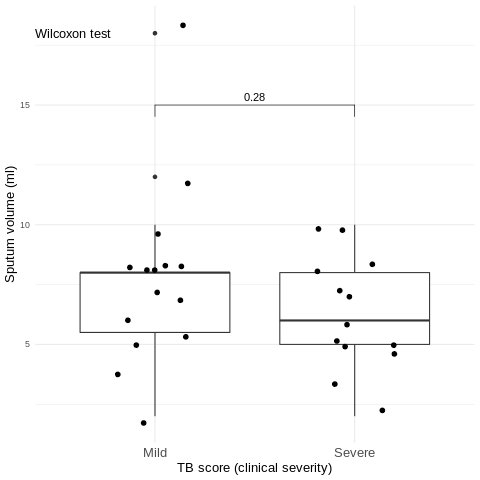

In [11]:
%%R
tbscore_comparisons <- list( c("Mild","Severe"))

sputum_volume_by_tbscore_plot <- ggplot(data=sputum_characteristics, aes(y=volumeml, x=worsetbscore)) + 
                                            geom_boxplot() + 
                                            geom_jitter(size=2, position=position_jitter(0.2)) + 
                                            stat_compare_means(method="wilcox.test", label.y=15, 
                                                               comparisons=tbscore_comparisons, na.rm=TRUE) + 
                                            annotate("text", label="Wilcoxon test", x=-Inf, y=18, hjust=0, 
                                                     size=4.5) + 
                                            labs(x="TB score (clinical severity)", y="Sputum volume (ml)") +
                                            theme_minimal() + 
                                            theme(plot.title = element_text(face="bold", hjust=0,size=14),
                                                  plot.subtitle = element_text(hjust=0,size=12),
                                                  axis.text.x=element_text(size=13), 
                                                  axis.title=element_text(size=13))

sputum_volume_by_tbscore_plot

**Sputum volume by abnormality of Chest X-rays**

In [12]:
%%R
sputum_vol_and_cxr <- dplyr::distinct(asv16s_mapping_ids[,c("SpecimenID","SubjectID")])
rownames(sputum_vol_and_cxr) <- sputum_vol_and_cxr$SpecimenID
sputum_vol_and_cxr <- na.omit(sputum_vol_and_cxr[rownames(sputum_characteristics),])
sputum_vol_and_cxr$volumeml <- sputum_characteristics[rownames(sputum_vol_and_cxr),"volumeml"]
sputum_vol_and_cxr$xraysevere_bin <- patients_clinical_data[sputum_vol_and_cxr$SubjectID, "xraysevere"]
sputum_vol_and_cxr[which(sputum_vol_and_cxr$xraysevere_bin != "Normal"),"xraysevere_bin"] <- "Abnormal"
sputum_vol_and_cxr$xraysevere_bin <- factor(sputum_vol_and_cxr$xraysevere_bin, levels=c("Normal","Abnormal"))
head(sputum_vol_and_cxr)

       SpecimenID SubjectID volumeml xraysevere_bin
S00341     S00341    H00334       10           <NA>
S00309     S00309    H00303        5       Abnormal
S00179     S00179    H00181       10       Abnormal
S00160     S00160    H00159        8         Normal
S00465     S00465    H00461        8       Abnormal
S00458     S00458    H00454        5       Abnormal


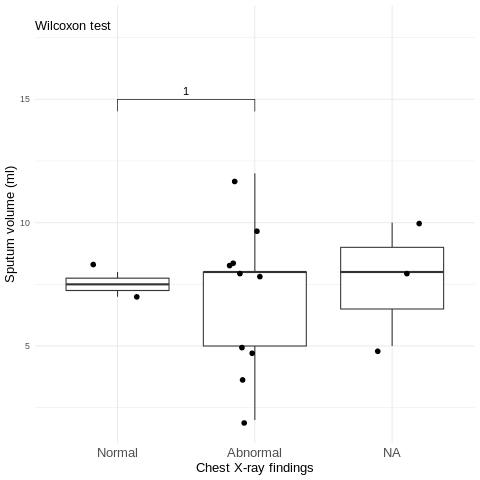

In [13]:
%%R
cxr_comparisons <- list( c("Normal","Abnormal") )
sputum_volume_by_cxr_plot <- ggplot(data=sputum_vol_and_cxr, aes(y=volumeml, x=xraysevere_bin)) + 
                                            geom_boxplot() + 
                                            geom_jitter(size=2, position=position_jitter(0.2)) + 
                                            stat_compare_means(method="wilcox.test", label.y=15, 
                                                               comparisons=cxr_comparisons, na.rm=TRUE) + 
                                            annotate("text", label="Wilcoxon test", x=-Inf, y=18, hjust=0, 
                                                     size=4.5) + 
                                            labs(x="Chest X-ray findings", y="Sputum volume (ml)") +
                                            theme_minimal() + 
                                            theme(plot.title = element_text(face="bold", hjust=0,size=14),
                                                  plot.subtitle = element_text(hjust=0,size=12),
                                                  axis.text.x=element_text(size=13), 
                                                  axis.title=element_text(size=13))

sputum_volume_by_cxr_plot

[1] 11.80556 11.11111


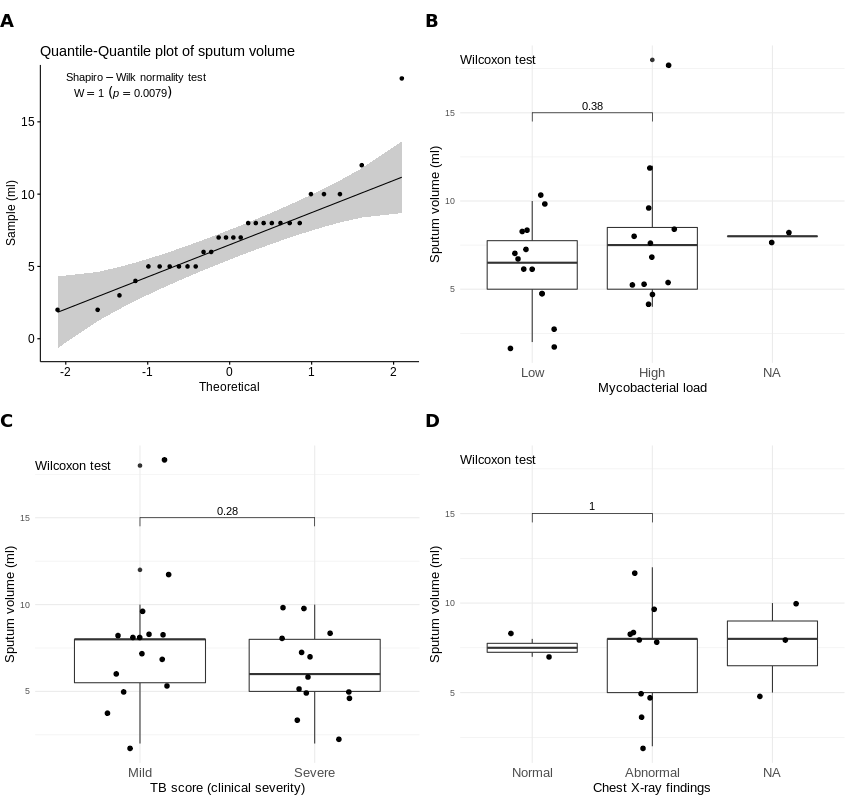

In [14]:
%%R -w 850 -h 800
print(par("din"))
heatmap_layout <- rbind(c(1,1,2,2),
                        c(3,3,4,4),
                        c(5,5,6,6),
                        c(7,7,8,8))
sputum_volume_by_tb_manifestations_panel <- grid.arrange(grobs=list(textGrob("A",just="left", x=unit(0, "npc"), 
                                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                                    textGrob("B",just="left", x=unit(0, "npc"), 
                                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                                    sputum_volume_shapiro_plot, 
                                                                    sputum_volume_by_mycobacterial_load_plot, 
                                                                    textGrob("C",just="left", x=unit(0, "npc"), 
                                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                                    textGrob("D",just="left", x=unit(0, "npc"), 
                                                                             gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                                    sputum_volume_by_tbscore_plot, 
                                                                    sputum_volume_by_cxr_plot), 
                                                         layout_matrix=heatmap_layout, heights=c(0.05,0.45,0.05,0.45))
sputum_volume_by_tb_manifestations_panel_file <- "./reports/figures/sputum_volume_by_disease_manifestations.svg"
ggsave(sputum_volume_by_tb_manifestations_panel_file,sputum_volume_by_tb_manifestations_panel, 
       width=11.81, height=11.111)